In [1]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools
import math

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys
from CZwave3 import CZpulse

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0
opts = qt.solver.Options(nsteps=10000)

5.775981884960281 6.611625529437035


In [2]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [3]:
def paulis_set(Nq, n):
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=n))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for Two qubit gates
def _tr(Ope, p, q, paulis, Nq, n):
    
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(Wq)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b)
    a = Wp * c
    mat = a.full()
    return a.tr()

def agf(Ope, target, Nq, n):
    
    d = 2**n
    paulis = paulis_set(Nq, n)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq, n)/d
            u = _tr(target, p, q, paulis, Nq, n)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

def Leakage_in_2Qsys(Ope,Nq):
    qproj = qt.qdiags([1 if i<2 else 0 for i in range(Nq)],0)
    proj=qt.tensor(qproj,qproj)
    d=4
    _L1=0
    for i in range(2):
        for j in range(2):
            rho=iniState2Qsys(Nq,Nq,i,j,'rho')
            mat=Ope.dag()*rho*Ope
            mat_in_subspace=proj.dag()*mat*proj
            _L1=_L1+mat_in_subspace.tr()
    L1=1-_L1/d
    return L1

## Pulse shape
---

In [4]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale

#tss=[]
#nss=[]
#shapess=[]

def MW_shaped(t,args):
    
    amp = args['mwamp']
    shape = args['shape'] 
    steps=args['steps']

    #tss.append(t)
    if int(t*steps)>=len(shape):
        n=len(shape)-1
    else:
        n=int(t*steps)
    #nss.append(n)
    #shapess.append(shape[n])
    return amp * shape[n]

## Parameters
---

In [5]:
# Q1
Ej1 = 17
Ec1 = 0.27
# Q2
Ej2 = 22
Ec2 = 0.27

###### qubit [GHz] ######
Nq = 3
Q1 = Tunabletransmon(EC=Ec1,EJmax=Ej1,Nq=Nq)
Q2 = Tunabletransmon(EC=Ec2,EJmax=Ej2,Nq=Nq)
wq1s=Q1.enes
wq2s=Q2.enes
fq1=wq1s[1]
fq2=wq2s[1]
print(fq1)
print(fq2)

J=0.015 #[GHz]
QQ=QQ(Q1,Q2,J)

5.775981884960281
6.611625529437035


## Hamiltonian assembling
---

In [6]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq1 = qt.qeye(Nq)
Iq2 = qt.qeye(Nq)
####### effective N-level pauli #######
pI = pI_N(Nq)
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

X1 = qt.tensor(px, Iq2)
Y1 = qt.tensor(py, Iq2)
Z1 = qt.tensor(pz, Iq2)
e_ops = [X1, Y1, Z1]

###### Assembling Lab frame Hamiltonian ######
# 2qubit-labframe
c1 = c(Nq)
C1 = qt.tensor(c1, Iq2)
c2 = c(Nq)
C2 = qt.tensor(Iq1,c2)

Hq1_lab = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2)
Hq2_lab = qt.tensor(Iq1,Hq_rot(Nq, wq2s, 0))
Hint = QQ.Hint12*(2*pi)
Hlab = Hq1_lab + Hq2_lab + Hint

#2qubit-rotatingframe
#Hq1_rot = Hq1_lab
Hq1_rot = qt.tensor(Hq_rot(Nq, wq1s, fq1), Iq2)*(2*pi)
rot2 = Hq_rot(Nq,[0,0,Q2.anh*(2*pi)],fq1*(2*pi))
print(rot2)
q2Freqs = qt.qdiags(np.arange(0,Q2.Nq,1),0)
Hq2_t_ind = qt.tensor(Iq1, rot2) #Hq2_rot(constant term)
Hq2_t_dep = qt.tensor(Iq1, q2Freqs) #Hq2_rot(modulation term)
H_rot = [Hq1_rot + Hq2_t_ind + Hint, [Hq2_t_dep, MW_shaped]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.        ]
 [  0.         -36.29156451   0.        ]
 [  0.           0.         -74.46330962]]


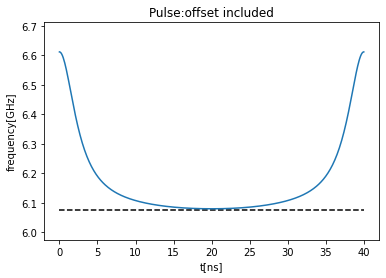

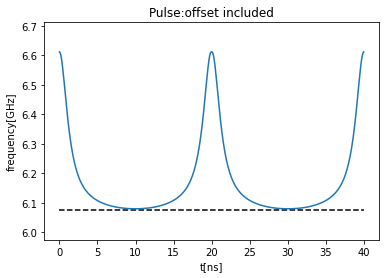

In [7]:
Tg_standard = int(1/(2*np.sqrt(2)*J))
Tg=40
step=10

pulsesystem=CZpulse(Q1,Q2,J,the_f=0.925,lambda2=0.0725,tg=Tg,steps=step)
qFreq20 = pulsesystem.qFreq20
mwamp = 2*pi
t_list1,adi=pulsesystem.flux_to_pulse(offset=0,pulsetype='Adiabatic',PLOT=True)
t_list2,net=pulsesystem.flux_to_pulse(offset=0,pulsetype='Net-Zero',PLOT=True)

#t_list2,nzcurrent=pulsesystem.netzerocurrent(offset=0.01,PLOT=True)
#t_list3,nzpulse=pulsesystem.flux_to_pulse(offset=0.001,pulsetype='Net-Zero',PLOT=True)

args1 = {'mwamp':mwamp, 'shape':adi, 'steps':step}
args2 = {'mwamp':mwamp, 'shape':net, 'steps':step}

In [8]:
H_on_resonance = Hq1_rot + Hq2_t_ind + Hint + Hq2_t_dep*pulsesystem.qFreq20*(2*pi)
#H_on_resonance

In [9]:
ini_state=qt.tensor(iniState1Qsys(Nq,1,'rho'),(px+pI)/2)

In [10]:
qproj = qt.qdiags([1 if i<2 else 0 for i in range(Nq)],0)
proj=qt.tensor(qproj,qproj)

# target Operator
onestate=iniState1Qsys(3,1,'rho')
cz=proj-2*qt.tensor(onestate,onestate)

In [11]:
res1 = qt.propagator(H_rot, t_list1,[],args1, parallel=False, options=qt.Options(nsteps=10000))
prop_fin1=proj.dag()*res1[-1]*proj
prop_fin1

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          9.83355260e-01+0.18169266j
   0.00000000e+00+0.j         -6.21861769e-05+0.00045598j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -8.30388284e-05+0.00045228j
   0.00000000e+00+0.j          9.88175270e-01+0.15332783j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j       

In [12]:
res2 = qt.propagator(H_rot, t_list2,[],args2, parallel=False, options=qt.Options(nsteps=10000))
prop_fin2=proj.dag()*res2[-1]*proj
prop_fin2

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          9.95771872e-01-0.09174641j
   0.00000000e+00+0.j          1.43146394e-04-0.00457844j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.48547249e-04-0.00457738j
   0.00000000e+00+0.j          9.88183929e-01+0.15320424j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j       

## Fidelity

In [13]:
target = qt.to_super(cz)
Fave1, Fe1, prb1 = agf(qt.to_super(prop_fin1), target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave1*100))

Fave = 97.83


In [14]:
Fave2, Fe2, prb2 = agf(qt.to_super(prop_fin2), target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave2*100))

Fave = 99.25+0.00j


In [15]:
L1=Leakage_in_2Qsys(prop_fin1,3)
print(L1)
L2=Leakage_in_2Qsys(prop_fin2,3)
print(L2)

0.006061130480432331
0.0008241173714074179


In [16]:
"""
Tg=40
step=10

offsetlabel = np.arange(0,21)
offsets = np.arange(0,21)*1e-5
pulsesystem = CZpulse(Q1,Q2,J,the_f=0.925,lambda2=0.075,gatetime=Tg,steps=step)
Faves1=[]
Faves2=[]
for offset in offsets:
    
    t_list1,adi=pulsesystem.flux_to_pulse(offset=offset,pulsetype='Adiabatic')
    args1 = {'mwamp':mwamp, 'shape':adi, 'steps':step}
    res1 = qt.propagator(H_rot, t_list1,[],args1, parallel=False, options=qt.Options(nsteps=10000))
    prop_fin1=proj.dag()*res1[-1]*proj
    Fave1 = agf(qt.to_super(prop_fin1), target, Nq, 2)[0]*100
    Faves1.append(Fave1)

    t_list2,net=pulsesystem.flux_to_pulse(offset=offset,pulsetype='Net-Zero')
    args2 = {'mwamp':mwamp, 'shape':net, 'steps':step}
    res2 = qt.propagator(H_rot, t_list2,[],args2, parallel=False, options=qt.Options(nsteps=10000))
    prop_fin2=proj.dag()*res2[-1]*proj
    Fave2 = agf(qt.to_super(prop_fin2), target, Nq, 2)[0]*100
    Faves2.append(Fave2)
"""

"\nTg=40\nstep=10\n\noffsetlabel = np.arange(0,21)\noffsets = np.arange(0,21)*1e-5\npulsesystem = CZpulse(Q1,Q2,J,the_f=0.925,lambda2=0.075,gatetime=Tg,steps=step)\nFaves1=[]\nFaves2=[]\nfor offset in offsets:\n    \n    t_list1,adi=pulsesystem.flux_to_pulse(offset=offset,pulsetype='Adiabatic')\n    args1 = {'mwamp':mwamp, 'shape':adi, 'steps':step}\n    res1 = qt.propagator(H_rot, t_list1,[],args1, parallel=False, options=qt.Options(nsteps=10000))\n    prop_fin1=proj.dag()*res1[-1]*proj\n    Fave1 = agf(qt.to_super(prop_fin1), target, Nq, 2)[0]*100\n    Faves1.append(Fave1)\n\n    t_list2,net=pulsesystem.flux_to_pulse(offset=offset,pulsetype='Net-Zero')\n    args2 = {'mwamp':mwamp, 'shape':net, 'steps':step}\n    res2 = qt.propagator(H_rot, t_list2,[],args2, parallel=False, options=qt.Options(nsteps=10000))\n    prop_fin2=proj.dag()*res2[-1]*proj\n    Fave2 = agf(qt.to_super(prop_fin2), target, Nq, 2)[0]*100\n    Faves2.append(Fave2)\n"

In [17]:
"""
plt.figure()
plt.plot(offsetlabel,Faves1,label='Unipolar-Adiabatic')
plt.plot(offsetlabel,Faves2,label='Net-Zero')
plt.xlabel('[$10^{-5}\Phi_0$]')
plt.ylabel('Fidelity(%)')
plt.legend()
plt.show()
"""

"\nplt.figure()\nplt.plot(offsetlabel,Faves1,label='Unipolar-Adiabatic')\nplt.plot(offsetlabel,Faves2,label='Net-Zero')\nplt.xlabel('[$10^{-5}\\Phi_0$]')\nplt.ylabel('Fidelity(%)')\nplt.legend()\nplt.show()\n"

In [18]:
"""
mat1=prop_fin1.full()
phase01=np.angle(mat1[1][1])
phase10=np.angle(mat1[3][3])
phase11=np.angle(mat1[4][4])
conditional_phase=(phase11-phase01-phase10)/pi
print('phase01:{:.3f}'.format(phase01))
print('phase10:{:.3f}'.format(phase10))
print('phase11:{:.3f}'.format(phase11))
print('conditional_phase:{:.3f}pi'.format(conditional_phase))
"""

"\nmat1=prop_fin1.full()\nphase01=np.angle(mat1[1][1])\nphase10=np.angle(mat1[3][3])\nphase11=np.angle(mat1[4][4])\nconditional_phase=(phase11-phase01-phase10)/pi\nprint('phase01:{:.3f}'.format(phase01))\nprint('phase10:{:.3f}'.format(phase10))\nprint('phase11:{:.3f}'.format(phase11))\nprint('conditional_phase:{:.3f}pi'.format(conditional_phase))\n"

In [21]:
"""
mat2=prop_fin2.full()
phase01=np.angle(mat2[1][1])
phase10=np.angle(mat2[3][3])
phase11=np.angle(mat2[4][4])
conditional_phase=(phase11-phase01-phase10)/pi
print('phase01:{:.3f}'.format(phase01))
print('phase10:{:.3f}'.format(phase10))
print('phase11:{:.3f}'.format(phase11))
print('conditional_phase:{:.3f}pi'.format(conditional_phase))
"""

"\nmat2=prop_fin2.full()\nphase01=np.angle(mat2[1][1])\nphase10=np.angle(mat2[3][3])\nphase11=np.angle(mat2[4][4])\nconditional_phase=(phase11-phase01-phase10)/pi\nprint('phase01:{:.3f}'.format(phase01))\nprint('phase10:{:.3f}'.format(phase10))\nprint('phase11:{:.3f}'.format(phase11))\nprint('conditional_phase:{:.3f}pi'.format(conditional_phase))\n"

['Tg:38.0', 'λ2:0.0875', 'θf:0.945', 0.8962696175367293]
['Tg:39.0', 'λ2:0.0625', 'θf:0.835', 0.9633643791049817]
['Tg:40.0', 'λ2:0.0875', 'θf:0.895', 0.9966617005145151]
['Tg:41.0', 'λ2:0.1125', 'θf:0.955', 0.941606307997717]
['Tg:42.0', 'λ2:0.1000', 'θf:0.805', (0.9381328380092193+3.469446951953614e-18j)]
['Tg:43.0', 'λ2:-0.0875', 'θf:0.940', (0.975998186569179+6.938893903907229e-19j)]
['Tg:44.0', 'λ2:-0.0750', 'θf:0.970', (0.9539694752610051-6.938893903907229e-19j)]
['Tg:45.0', 'λ2:-0.0625', 'θf:0.845', 0.9099110443269469]

2677.9109814167023


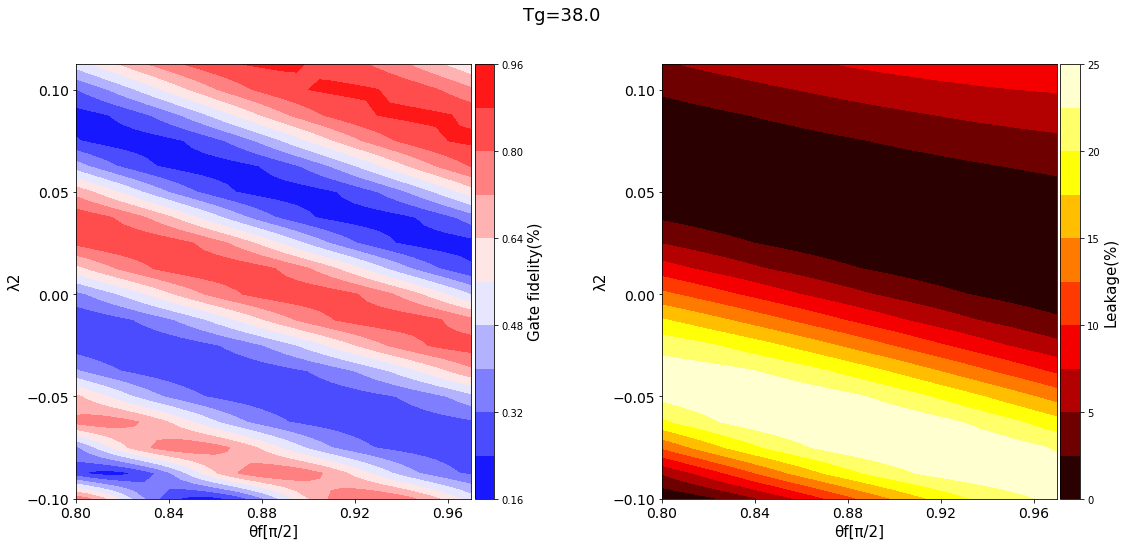

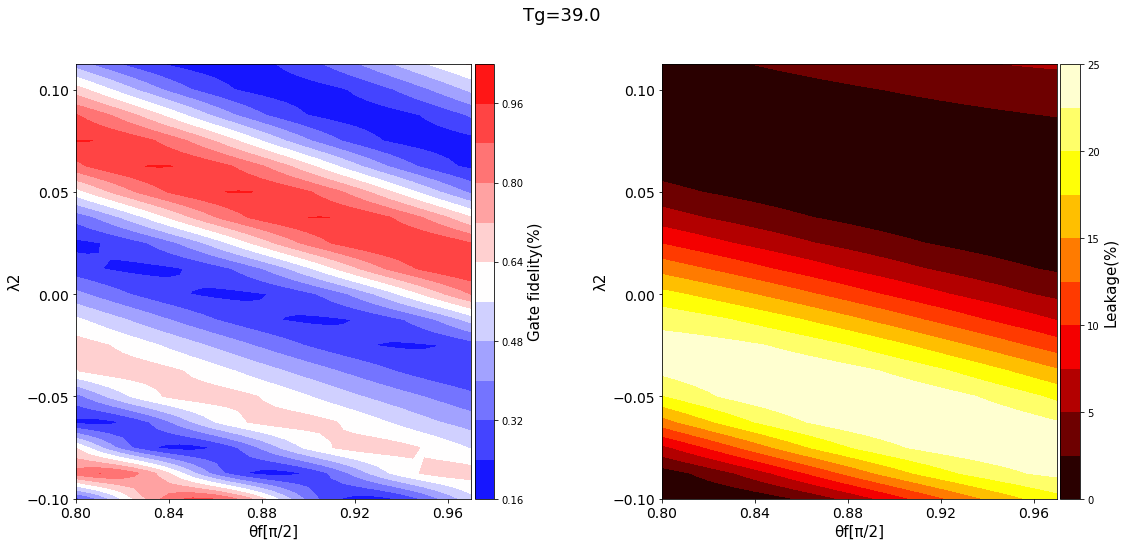

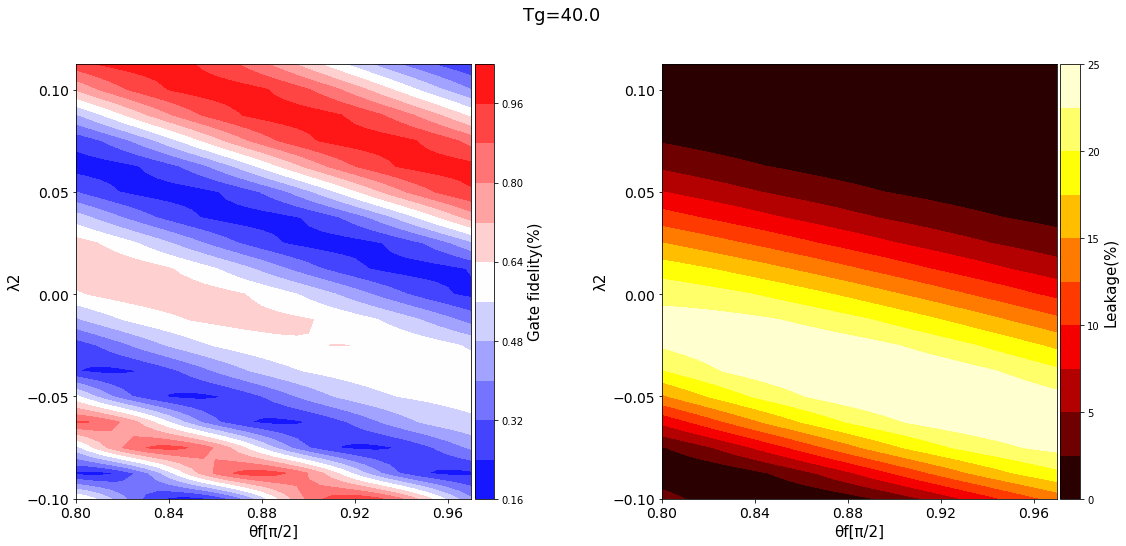

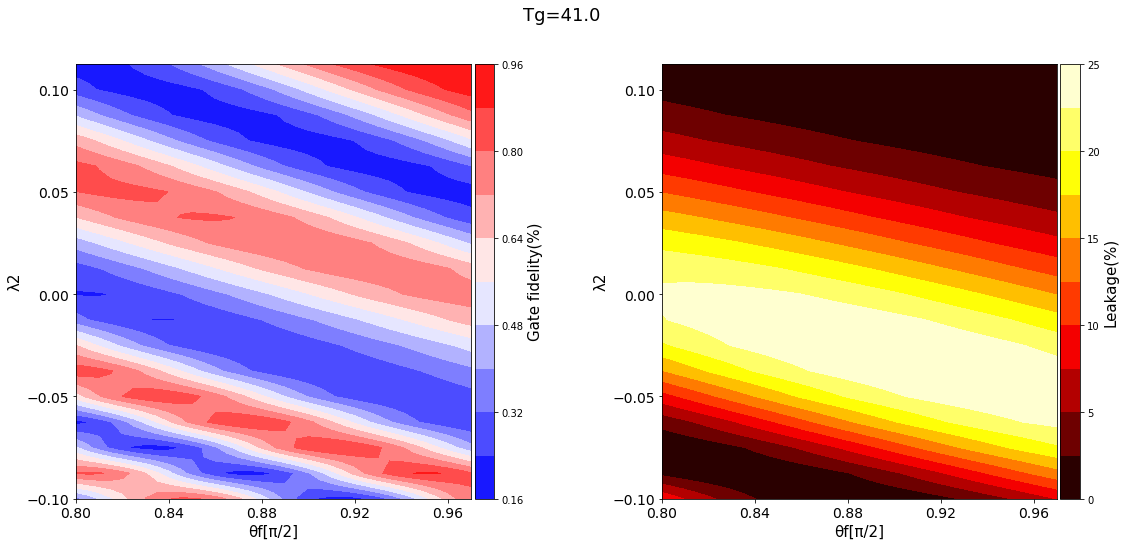

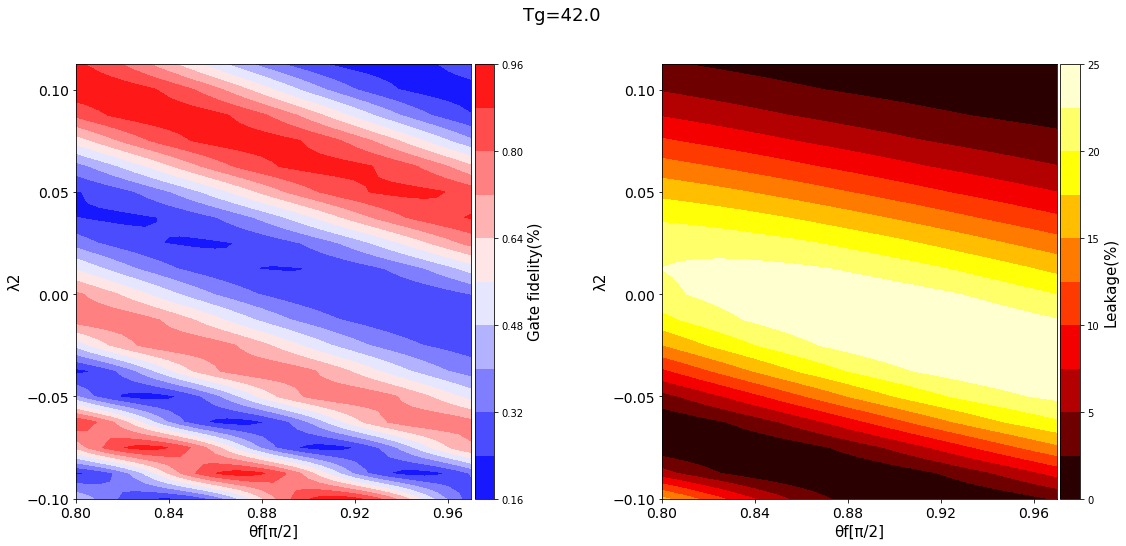

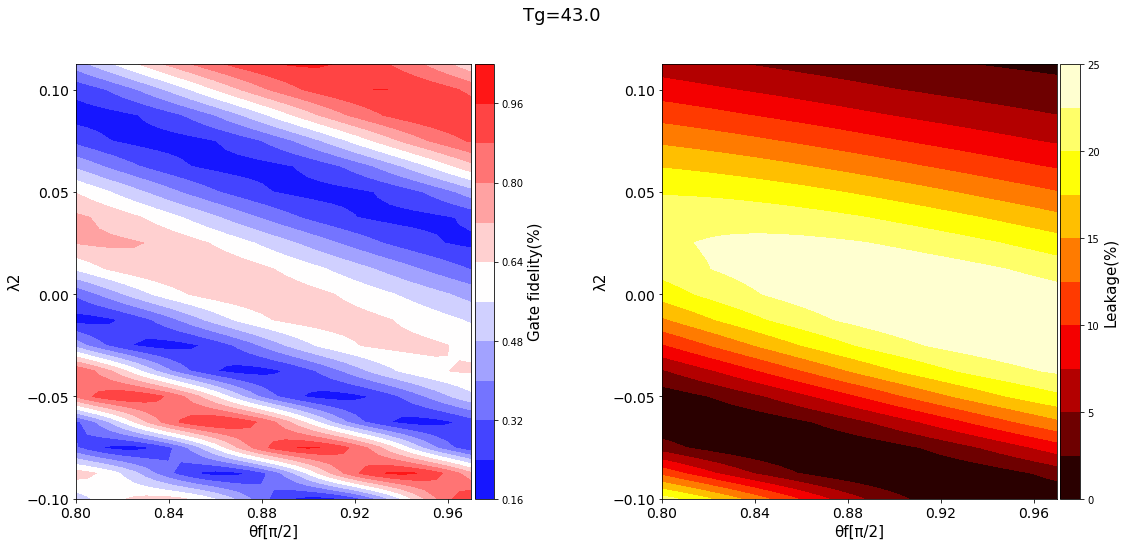

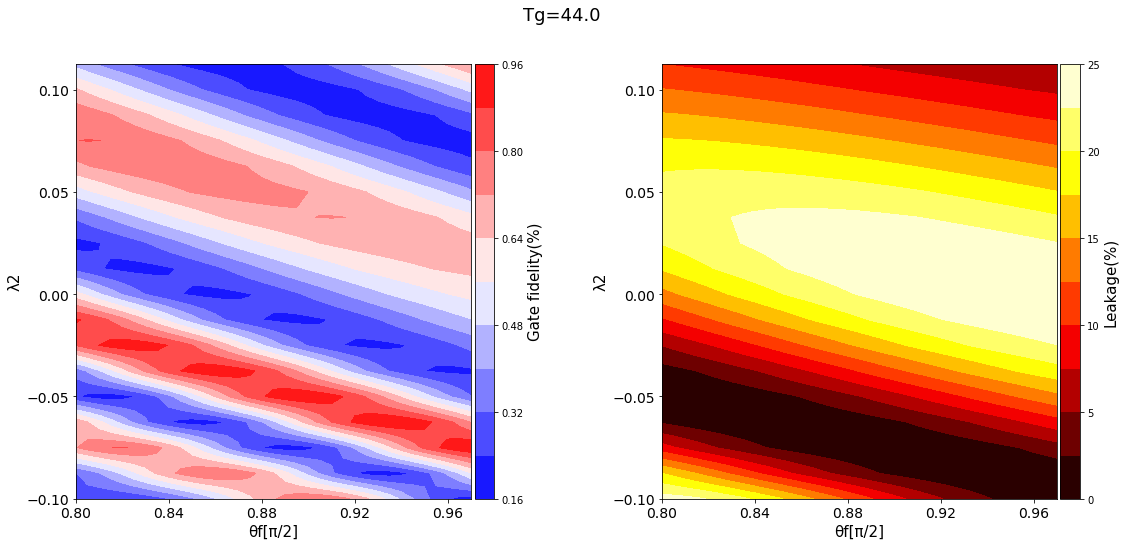

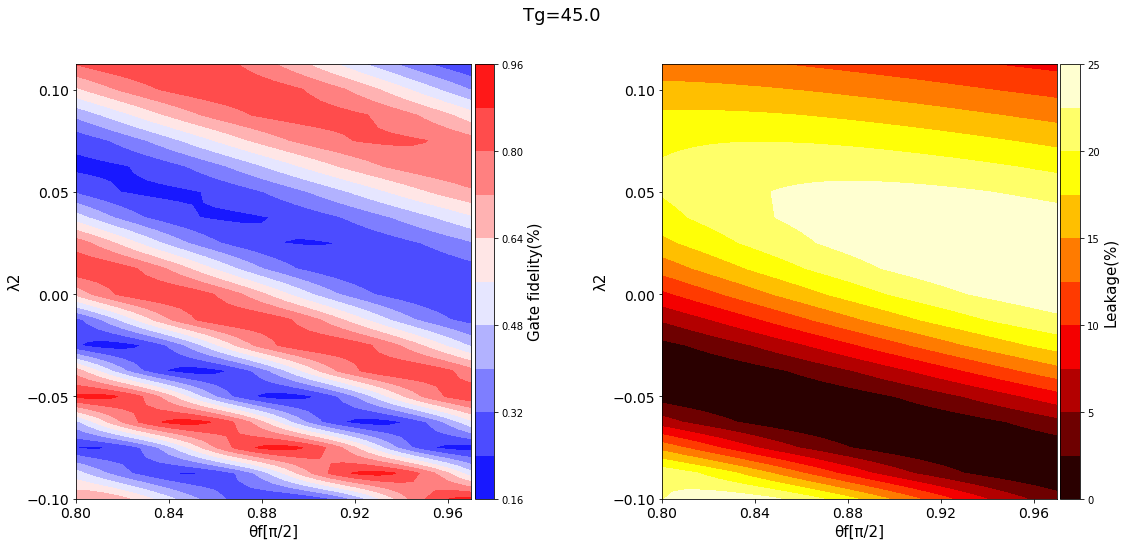

In [22]:
import time
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable

mwamp=2*pi
thef_list=np.arange(0.8, 0.975, 0.005)
lambda2_list=np.arange(-0.10, 0.125, 0.0125)
Tg_list=np.arange(38,46)

start = time.time()
for Tg in tqdm(Tg_list):
    avelist=[]
    avemaxlist=[]
    Leakmap=[]
    for lambda2 in lambda2_list:
        _avelist=[]
        _infolist=[]
        Leaklist=[]
        for the_f in thef_list:
            pulsesystem2=CZpulse(Q1,Q2,J,the_f=the_f,lambda2=lambda2,tg=Tg,steps=step)
            t_list,net=pulsesystem2.netzeropulse(PLOT=False)
            args = {'mwamp':mwamp, 'shape':net ,'steps':step}
            res = qt.propagator(H_rot, t_list,[],args, parallel=False, options=qt.Options(nsteps=1000))
            prop_fin=proj.dag()*res[-1]*proj
            L=Leakage_in_2Qsys(prop_fin,3)*100
            fave= agf(qt.to_super(prop_fin), target, Nq, 2)[0]
            _infolist.append([fave,the_f])
            _avelist.append(fave)
            Leaklist.append(L)
        _maxinfo=sorted(_infolist,key=lambda x:x[0])[-1]
        _avemax=['Tg:{:.1f}'.format(Tg),'λ2:{:.4f}'.format(lambda2),'θf:{:.3f}'.format(_maxinfo[1]),_maxinfo[0]]
        avemaxlist.append(_avemax)
        avelist.append(_avelist)
        Leakmap.append(Leaklist)

    avemaxlist=sorted(avemaxlist,key=lambda x:x[3])
    print(avemaxlist[-1])

    xx, yy = np.meshgrid(thef_list,lambda2_list)

    fig, axes = plt.subplots(figsize=(18,8),nrows=1, ncols=2, sharex=False)
    plt.subplots_adjust(wspace=0.4)
    fig.suptitle('Tg={:.1f}'.format(Tg), fontsize=18)

    ax1=axes[0]
    ax2=axes[1]
    im1 = ax1.contourf(xx, yy,avelist,cmap='bwr',levels=10)
    ax1.grid(False)
    ax1.set_xlabel('θf[π/2]',fontsize=15)
    ax1.set_ylabel('λ2',fontsize=15)
    ax1.set_xticks([0.80, 0.84, 0.88, 0.92, 0.96])
    ax1.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
    ax1.tick_params(labelsize=14)
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar1 = fig.colorbar(im1, cax=cax1)
    cbar1.set_label('Gate fidelity(%)',size=15)

    im2=ax2.contourf(xx, yy,Leakmap,cmap='hot',levels=10)
    ax2.grid(False)
    ax2.set_xlabel('θf[π/2]',fontsize=15)
    ax2.set_ylabel('λ2',fontsize=15)
    ax2.set_xticks([0.80, 0.84, 0.88, 0.92, 0.96])
    ax2.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
    ax2.tick_params(labelsize=14)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cbar2 = fig.colorbar(im2, cax=cax2)
    cbar2.set_label('Leakage(%)',size=15)

    plt.savefig('C:/Sota_Ino/Scripts/TestKankyo/cQEDSim/core/hikaku_Netzero_step10_2/Tg={}.png'.format(Tg))
end=time.time()
passedtime=end-start
print('Time:{}m{}s'.format(str(passedtime//60),str(passedtime%60))